<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as utils
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

__import__('warnings').filterwarnings("ignore")

sns.set(style='darkgrid', font_scale=1.2)

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
# перед запуском этого нужно положить kaggle.json в корень сессионного хранилища

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

100% 3.99G/3.99G [00:40<00:00, 99.4MB/s]
100% 3.99G/3.99G [00:40<00:00, 106MB/s] 


In [5]:
%%time

print('Распаковываю архив...')
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'
print('Готово!!!')

Распаковываю архив...
Готово!!!
CPU times: user 175 ms, sys: 46.4 ms, total: 221 ms
Wall time: 31.8 s


In [6]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('CUDA is available!  Training on GPU ...')    
else:
    print('CUDA is not available.  Training on CPU ...')

device = torch.device(("cpu", "cuda")[train_on_gpu])

CUDA is not available.  Training on CPU ...


In [7]:
%%time

#TODO: build dataloader and transfer it to device
        
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)        


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

image_size = 128
# image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

DATA_DIR = './images/'

dataset = ImageFolder(DATA_DIR,
                               transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(*stats),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader = DeviceDataLoader(dataloader, device)

CPU times: user 11 ms, sys: 751 µs, total: 11.8 ms
Wall time: 15.2 ms


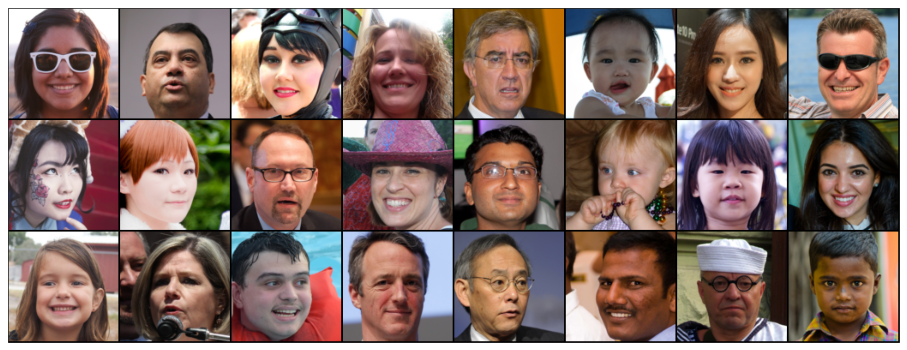

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=24):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


images, _ = next(iter(dataloader))        
show_images(images.cpu())

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [4]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [8]:
# дискриминатор принимает на вход изображение (тензор размера 
# 3 x image_size x image_size) и выдает вероятность того, 
# что изображение настоящее (тензор размера 1)
discriminator = nn.Sequential(

    nn.Conv2d(3, image_size//2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size//2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size//2, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),

    # nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(image_size),
    # nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*4),
    nn.LeakyReLU(0.2, inplace=True),
        
    nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = to_device(discriminator, device)

In [6]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [9]:
latent_size = 256  # choose latent size

# генератор принимает на вход тензор шумов размера latent_size x 1 x 1 и 
# генерирует изображение размера 3 x image_size x image_size
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, image_size*8, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(image_size*8),
    nn.ReLU(True),

    nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.ReLU(True),

    # nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    
    nn.ConvTranspose2d(image_size, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

generator = to_device(generator, device)

In [8]:
generator

Sequential(
  (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

torch.Size([64, 3, 128, 128])
CPU times: user 1.31 s, sys: 786 ms, total: 2.1 s
Wall time: 6.54 s


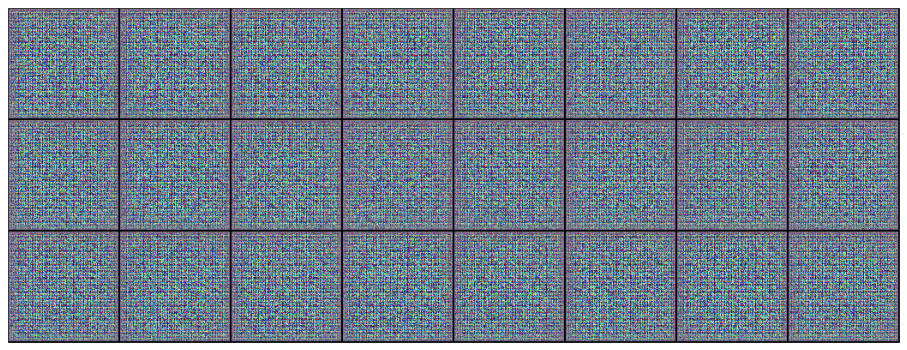

In [12]:
%%time

# Посмотрим, как выглядит шум, из которого будут генерироваться изображения

xb = torch.randn(batch_size, latent_size, 1, 1, device=device) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [10]:
lr = 0.0001
epochs = 50

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [14]:
# TODO: build optimizers and train your GAN

def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    min_loss_g = np.inf
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, "
              "real_score: {:.4f}, fake_score: {:.4f}".format(epoch + 1, epochs,
                                                              losses_g[-1],
                                                              losses_d[-1],
                                                              real_scores[-1],
                                                              fake_scores[-1]))
        if epoch > 9 and losses_g[-1] < min_loss_g:
            print(f'Generator loss lowest from {min_loss_g} to {losses_g[-1]}. Saving weights')
            min_loss_g = losses_g[-1]
            torch.save(model["generator"].state_dict(), f'gen_best_weights_{epochs}.pth')
            torch.save(model["discriminator"].state_dict(), f'gen_best_discriminator_weights_{epochs}.pth')
        
        # Save generated images + веса генератора и дискриминатора
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
            torch.save(model["generator"].state_dict(), f'generator_weights_{epochs}.pth')
            torch.save(model["discriminator"].state_dict(), f'discriminator_weights_{epochs}.pth')
    
    return losses_g, losses_d, real_scores, fake_scores

In [15]:
%%time
history = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 12.8503, loss_d: 0.4467, real_score: 0.9154, fake_score: 0.1281


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 14.1899, loss_d: 0.5523, real_score: 0.9209, fake_score: 0.1165


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 11.4741, loss_d: 0.3648, real_score: 0.8972, fake_score: 0.1068


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 11.8836, loss_d: 0.2760, real_score: 0.9195, fake_score: 0.0879


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 10.9726, loss_d: 0.1750, real_score: 0.9482, fake_score: 0.0641


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 11.0761, loss_d: 0.1228, real_score: 0.9514, fake_score: 0.0424


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 7.5506, loss_d: 0.0475, real_score: 0.9784, fake_score: 0.0224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 7.1116, loss_d: 0.0384, real_score: 0.9802, fake_score: 0.0163


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 6.2318, loss_d: 0.0247, real_score: 0.9860, fake_score: 0.0098


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 6.2991, loss_d: 0.0133, real_score: 0.9929, fake_score: 0.0059


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 6.5752, loss_d: 0.0125, real_score: 0.9930, fake_score: 0.0052
Generator loss lowest from inf to 6.575224695205688. Saving weights


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 6.4935, loss_d: 0.0107, real_score: 0.9941, fake_score: 0.0046
Generator loss lowest from 6.575224695205688 to 6.493498497009277. Saving weights


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 6.7925, loss_d: 0.0127, real_score: 0.9928, fake_score: 0.0038


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.8466, loss_d: 0.6591, real_score: 0.9312, fake_score: 0.0326


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.5599, loss_d: 0.4272, real_score: 0.9317, fake_score: 0.0270


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 4.7681, loss_d: 0.1104, real_score: 0.9575, fake_score: 0.0505
Generator loss lowest from 6.493498497009277 to 4.768140659332276. Saving weights


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 5.6096, loss_d: 0.0376, real_score: 0.9856, fake_score: 0.0217


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 6.0028, loss_d: 0.0174, real_score: 0.9933, fake_score: 0.0102


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 6.3344, loss_d: 0.0089, real_score: 0.9971, fake_score: 0.0059


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 6.0483, loss_d: 0.0072, real_score: 0.9975, fake_score: 0.0046


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 6.5185, loss_d: 0.0063, real_score: 0.9973, fake_score: 0.0035


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 6.5077, loss_d: 0.0045, real_score: 0.9980, fake_score: 0.0024


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 6.5521, loss_d: 0.0049, real_score: 0.9979, fake_score: 0.0028


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 6.7264, loss_d: 0.0039, real_score: 0.9980, fake_score: 0.0019


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 7.1216, loss_d: 0.0029, real_score: 0.9986, fake_score: 0.0015


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 7.2161, loss_d: 0.0103, real_score: 0.9929, fake_score: 0.0011


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 10.3796, loss_d: 0.5320, real_score: 0.9393, fake_score: 0.0415


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.9117, loss_d: 0.0316, real_score: 0.9857, fake_score: 0.0157


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 5.9513, loss_d: 0.0165, real_score: 0.9921, fake_score: 0.0084


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 6.1897, loss_d: 0.0106, real_score: 0.9949, fake_score: 0.0054


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 6.5334, loss_d: 0.0081, real_score: 0.9954, fake_score: 0.0034


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 6.2984, loss_d: 0.0073, real_score: 0.9960, fake_score: 0.0033


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 6.6723, loss_d: 0.0051, real_score: 0.9969, fake_score: 0.0019


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 6.9581, loss_d: 0.0037, real_score: 0.9977, fake_score: 0.0014


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 7.0459, loss_d: 0.0037, real_score: 0.9976, fake_score: 0.0013


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 7.2221, loss_d: 0.2835, real_score: 0.9517, fake_score: 0.0304


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.7323, loss_d: 0.5101, real_score: 0.8656, fake_score: 0.1332


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.5883, loss_d: 0.0763, real_score: 0.9618, fake_score: 0.0313
Generator loss lowest from 4.768140659332276 to 4.588257946968079. Saving weights


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.5981, loss_d: 0.4624, real_score: 0.8963, fake_score: 0.0991


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 5.1220, loss_d: 0.3090, real_score: 0.9194, fake_score: 0.0597


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.7903, loss_d: 0.1749, real_score: 0.9331, fake_score: 0.0704


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 6.0500, loss_d: 0.3276, real_score: 0.9104, fake_score: 0.0852


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.1777, loss_d: 0.4495, real_score: 0.8708, fake_score: 0.1395


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.6850, loss_d: 0.7325, real_score: 0.8586, fake_score: 0.1354


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.3485, loss_d: 0.4867, real_score: 0.8357, fake_score: 0.1721
Generator loss lowest from 4.588257946968079 to 3.3484779357910157. Saving weights


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 5.5579, loss_d: 0.2958, real_score: 0.8990, fake_score: 0.0975


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 7.1599, loss_d: 0.4963, real_score: 0.8955, fake_score: 0.1090


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 5.0084, loss_d: 0.5349, real_score: 0.8493, fake_score: 0.1443


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.8021, loss_d: 0.4985, real_score: 0.8526, fake_score: 0.1559


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.8591, loss_d: 0.5649, real_score: 0.8542, fake_score: 0.1401
Saving generated-images-0050.png
CPU times: user 2h 33min 47s, sys: 1min 27s, total: 2h 35min 14s
Wall time: 2h 35min 4s


##### Забрать с диска колаба файлы *.pth 

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

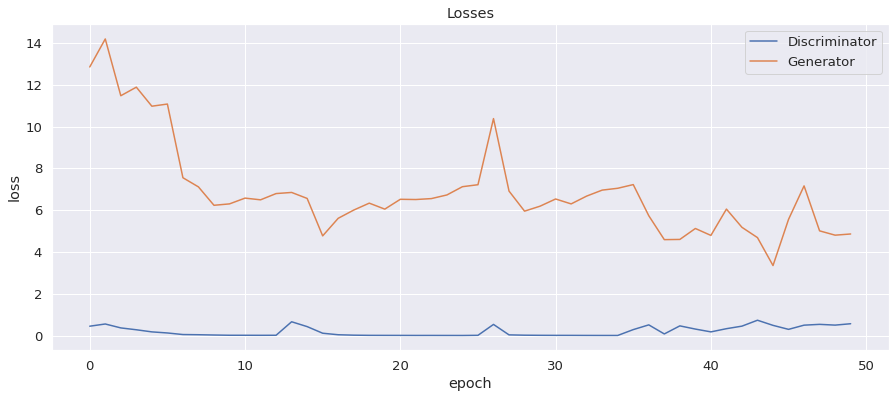

In [16]:
losses_g, losses_d, real_scores, fake_scores = history

plt.figure(figsize=(15, 6))
plt.plot(losses_d)
plt.plot(losses_g)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

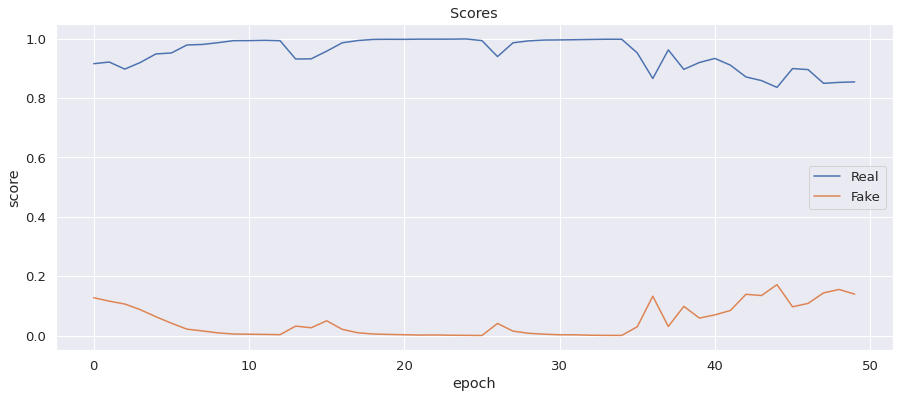

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores)
plt.plot(fake_scores)
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [18]:
%%time
n_images = 8
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

CPU times: user 2.39 ms, sys: 4 µs, total: 2.39 ms
Wall time: 2.4 ms


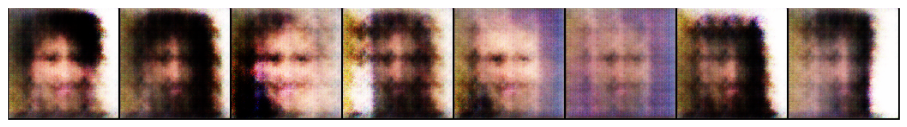

In [19]:
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [11]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE

In [14]:
if os.path.exists(f'generator_weights_{epochs}.pth'):
  torch.cuda.empty_cache()
  if train_on_gpu:
    model["discriminator"].load_state_dict(torch.load(f'discriminator_weights_{epochs}.pth'))
    model["generator"].load_state_dict(torch.load(f'generator_weights_{epochs}.pth'))
  else:      
    model["discriminator"].load_state_dict(torch.load(f'discriminator_weights_{epochs}.pth', map_location=torch.device('cpu')))
    model["generator"].load_state_dict(torch.load(f'generator_weights_{epochs}.pth', map_location=torch.device('cpu')))


In [12]:
!nvidia-smi

Thu Dec 15 17:12:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |    746MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
# device = torch.device(("cpu", "cuda")[0])
# generator = to_device(generator, device)

In [ ]:
%%time

noise = torch.randn(len(dataset), latent_size, 1, 1, device=device)

# создаём два тензора: со сгенерированными и настоящими лицами
fake_data = generator(noise)
fake_labels = torch.zeros(fake_data.size(0), 1, device=device)

true_data = [i[0] for i in tqdm(dataset)]
true_labels = torch.ones(len(true_data), 1, device=device)

# объединяем тензор со сгенерированными и настоящими лицами в один
all_labels = torch.cat((fake_labels.cpu(), true_labels.cpu()))
all_imgs = torch.cat((fake_data.cpu(), torch.stack(true_data).cpu()))

In [ ]:
%%time

# генерируем случайные индексы

# num_samples = 1000
num_samples = len(all_imgs)

idx = np.arange(len(all_imgs))
np.random.shuffle(idx)
idx = idx[:num_samples]

X = all_imgs.view(len(all_imgs), -1).detach().numpy()[idx]
y = all_labels.detach().numpy().ravel()[idx]

In [ ]:
%%time

cv = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)

In [ ]:
print(f'Accuracy: {np.mean(scores).round(3)}')

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
%%time

X = all_imgs.view(len(all_imgs), -1).detach().numpy()
y = all_labels.detach().numpy().ravel()

tsne = TSNE()
tsne_results = tsne.fit_transform(X)

In [ ]:
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='Latent Representation of faces' )
scatter = ax.scatter(
    x=X[:,0], 
    y=X[:,1], 
    c=y, 
    cmap=plt.cm.get_cmap('tab10'))
    
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()

Прокомментируйте получившийся результат: